(closed_cmr)=
# Estimating population size with capture-recapture

:::{post} January, 2026
:tags: ecology, hierarchical model, marginalization
:category: intermediate, howto
:author: Philip T. Patton
:::

Ecologists have been estimating population sizes with capture-recapture models for over a 100 years. The method appears to have been independently developed in 1889 by C.G. Johannes Petersen, who wanted to estimate the number of European Plaice (*Pleuronectes platessa*) at his Danish marine station, and in 1930 by Fredrick C. Lincoln, who was tasked with monitoring birds across the U.S. after the passage of the Migratory Bird Treaty Act in 1918. The very first application of capture-recapture appears to have been by Laplace, who was trying to estimate the size of France's human population in 1783. Since then, researchers have developed countless forms of the basic capture-recapture model to account for complexities that arise in sampling wildlife populations. 

The goal of these studies was to estimate the size of a population over a short period of time where it could reasonably be considered to be "closed," i.e., no births, deaths, immigration, or emigration. As a result, these are known as closed capture-recapture models (in contrast to open capture models, where the goal is estimating survival and recruitment).  The most basic form of capture-recapture involves capturing animals, marking them, releasing them, recapturing them on a later date, and determining the number of marked animals in the second sample. The process can be continued to include many samples (i.e., not just two). Then, we can estimate the probability of recapturing an individual, $p$, which we can use to estimate the population size, $N$. 

In this example, we'll estimate the size of a meadow vole population (*Microtus pennsylvanicus*), which was surveyed by Jim Nichols of the the US Geological Survey's Eastern Ecological Research Center in Maryland {cite:p}`nichols1984use`. Below is a meadow vole in all of its glory.

![](meadow-vole.jpg)


In [1]:
import os

import arviz.preview as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import binom


def invlogit(x):
    """Take the inverse logit, or expit, of a variable"""
    return 1 / (1 + np.exp(-x))

:::{include} ../extra_installs.md
:::

In [2]:
import pymc_extras as pmx

In [3]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
RANDOM_SEED = 1792
rng = np.random.default_rng(RANDOM_SEED)

## Basic capture-recapture model 

{cite:t}`nichols1984use` deployed a 10 by 10 grid of traps baited with corn, and checked the traps in $T=5$ consecutive morning to see if they contained a vole. Captured voles were marked with and and released. They captured $n_0=56$ voles in total. The observed dataset is a binary matrix of shape $(56, 5)$ where $1$ indicates that the individual was captured that morning. Researchers will often refer to each row as the "capture history" for that individual.

In [4]:
try:
    vole_data = np.loadtxt(os.path.join("..", "data", "microtus.txt"))
except FileNotFoundError:
    vole_data = np.loadtxt(pm.get_data("microtus.txt"))

# unpack the two portions of the dataset
observed_dataset = vole_data[:, :-1].astype(int)
body_mass = vole_data[:, -1].astype(int)
observed_dataset[:5]

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1]])

### Model $M_0$: constant capture probability

Researchers have christened the most common flavors of capture-recapture as $M_0$, $M_t$, $M_h$, $M_b$, with various combinations thereof. These flavors differ in how they model $p$. We'll start with $M_0$, which assumes a constant capture probability. 

There are several ways to parameterize $M_0$; we are going to use parameter expanded data augmentation {cite:p}`royle2009analysis`. Data augmentation works by setting an absurd upper limit to the population size, $M$. Then, we augment the observed dataset with $M-n_0$ all-zero capture histories. Each all-zero history either represents an individual that was never captured, or an individual that does not exist in the population. We can then estimate the inclusion probability $\psi$, which represents that one of the $M$ rows in the dataset represents a true individual in the population. When the capture probability is constant across occasions, we can represent the process as a zero-inflated binomial distribution 
$$
\begin{align*}
p &\sim \text{Uniform}(0, 1) \\
z_i &\sim \text{Bernoulli}(\psi) \\
y_{i, \bullet} &\sim \text{Binomial}(T, z_i p)
\end{align*}
$$
where $i$ is an index for individual $i=1,2,\dots,M$, $z_i=1$ if the individual truly exists within the population, and $y_{i, \bullet}$ is the total number of times that individual $i$ was captured. Then, the expected population size is $\hat{N}= \hat{\psi} * M$, or $N=\sum_{i=1}^M z_i$

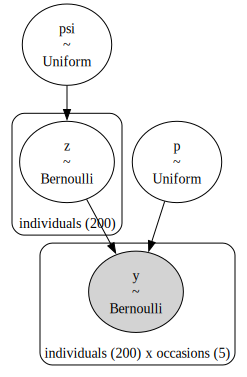

In [5]:
# augment the observed data with all zero capture histories
M = 200
n0, T = observed_dataset.shape
all_zero_histories = np.zeros((M - n0, T))
augmented_dataset = np.vstack((observed_dataset, all_zero_histories))

# we can sum the data since we're assuming constant capture probability
y_total = augmented_dataset.sum(axis=1)

# build the pymc model
coords = {"individuals": np.arange(M), "occasions": np.arange(T)}

with pm.Model(coords=coords) as m0:
    p = pm.Uniform("p", 0, 1)
    psi = pm.Uniform("psi", 0, 1)

    # included / excluded state
    z = pm.Bernoulli("z", psi, dims="individuals")

    # likelihood of capture given inclusion
    pm.Bernoulli("y", z[:, None] * p, observed=augmented_dataset, dims=["individuals", "occasions"])

pm.model_to_graphviz(m0)

In [6]:
# marginalize the model before sampling
m0_marginal = pmx.marginalize(m0, ["z"])
with m0_marginal:
    m0_idata = pm.sample(random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(m0_idata)

az.summary(m0_idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Output()

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
p,0.63,0.03,0.58,0.68,3719.19,2864.50,1.0,0.0,0.0
psi,0.28,0.03,0.24,0.34,3781.15,2956.02,1.0,0.0,0.0


In this case, $\hat{\psi} \approx 0.28$, so the expected population size is about $0.63 * 200 = 56.$ We can estimate the posterior distribution of $N$ by computing the probability that an individual was included in the population but never captured. Since the capture probability is fairly high, the estimated population size is just the number of captured individuals.

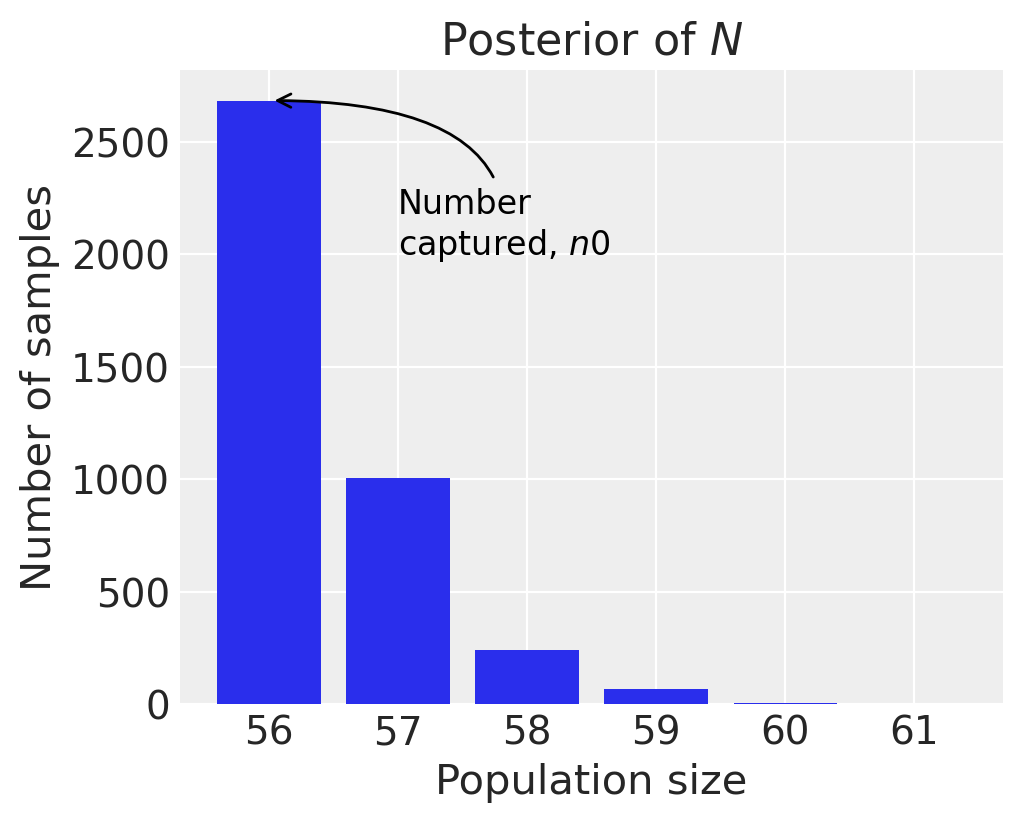

In [7]:
# az.extract flattens the chains
posterior = az.extract(m0_idata)
posterior_psi = posterior.psi.values
posterior_p = posterior.p.values

# posterior probability of being included in the population but not captured
prob_in_population = posterior_psi * binom.pmf(0, n=T, p=posterior_p)

# simulate the number of uncaptured animals in the population
posterior_uncaptured_count = rng.binomial(
    M - n0, prob_in_population / (prob_in_population + (1 - posterior_psi))
)
posterior_N = n0 + posterior_uncaptured_count

# plot the posterior of N
fig, ax = plt.subplots(figsize=(5, 4))

# bar plot looks a little better than a histogram here imo
N_values, N_counts = np.unique(posterior_N, return_counts=True)
ax.bar(N_values, N_counts)

ax.annotate(
    "Number\ncaptured, $n0$",
    ha="left",
    xy=(N_values[0], N_counts[0]),
    color="k",
    xytext=(n0 + 1, 2000),
    fontsize=12,
    arrowprops=dict(
        arrowstyle="->", color="k", linewidth=1, connectionstyle="angle3,angleA=90,angleB=0"
    ),
)

# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("Number of samples")
ax.set_title("Posterior of $N$")
ax.set_xlabel("Population size")

plt.show()

## Model $M_t:$ capture probability varies over time

Another common model structure, $M_t$, assumes that the capture probability varies over time, $p_t$ for $t=1,2,\dots,5$. To keep things simple, we will assume that $p_t$ is a fixed effect. As such, $y_{i,t}$ is now a Bernoulli random variable, and we will have to marginalize out the discrete latent state, $z_i$. 

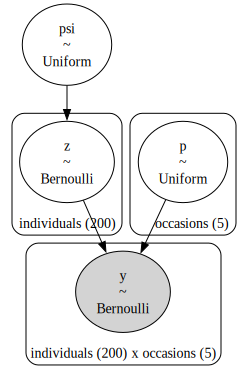

In [8]:
with pm.Model(coords=coords) as mt:

    # priors for the capture and inclusion probabilities
    psi = pm.Uniform("psi", 0, 1)
    p = pm.Uniform("p", 0, 1, dims="occasions")

    # included / excluded state
    z = pm.Bernoulli("z", psi, dims="individuals")

    # likelihood of capture given inclusion
    pm.Bernoulli("y", z[:, None] * p, observed=augmented_dataset, dims=["individuals", "occasions"])

pm.model_to_graphviz(mt)

In [9]:
# marginalize the model before sampling
mt_marginal = pmx.marginalize(mt, ["z"])
with mt_marginal:
    mt_idata = pm.sample(random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(mt_idata)

az.summary(mt_idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
p[0],0.57,0.06,0.46,0.67,4675.97,2679.62,1.0,0.0,0.0
p[1],0.70,0.06,0.60,0.79,6770.70,2994.49,1.0,0.0,0.0
p[2],0.67,0.06,0.56,0.76,6554.82,3241.18,1.0,0.0,0.0
p[3],0.62,0.07,0.51,0.72,6632.84,3269.39,1.0,0.0,0.0
p[4],0.58,0.06,0.47,0.68,5997.89,3243.38,1.0,0.0,0.0
psi,0.28,0.03,0.23,0.33,5100.88,3351.38,1.0,0.0,0.0


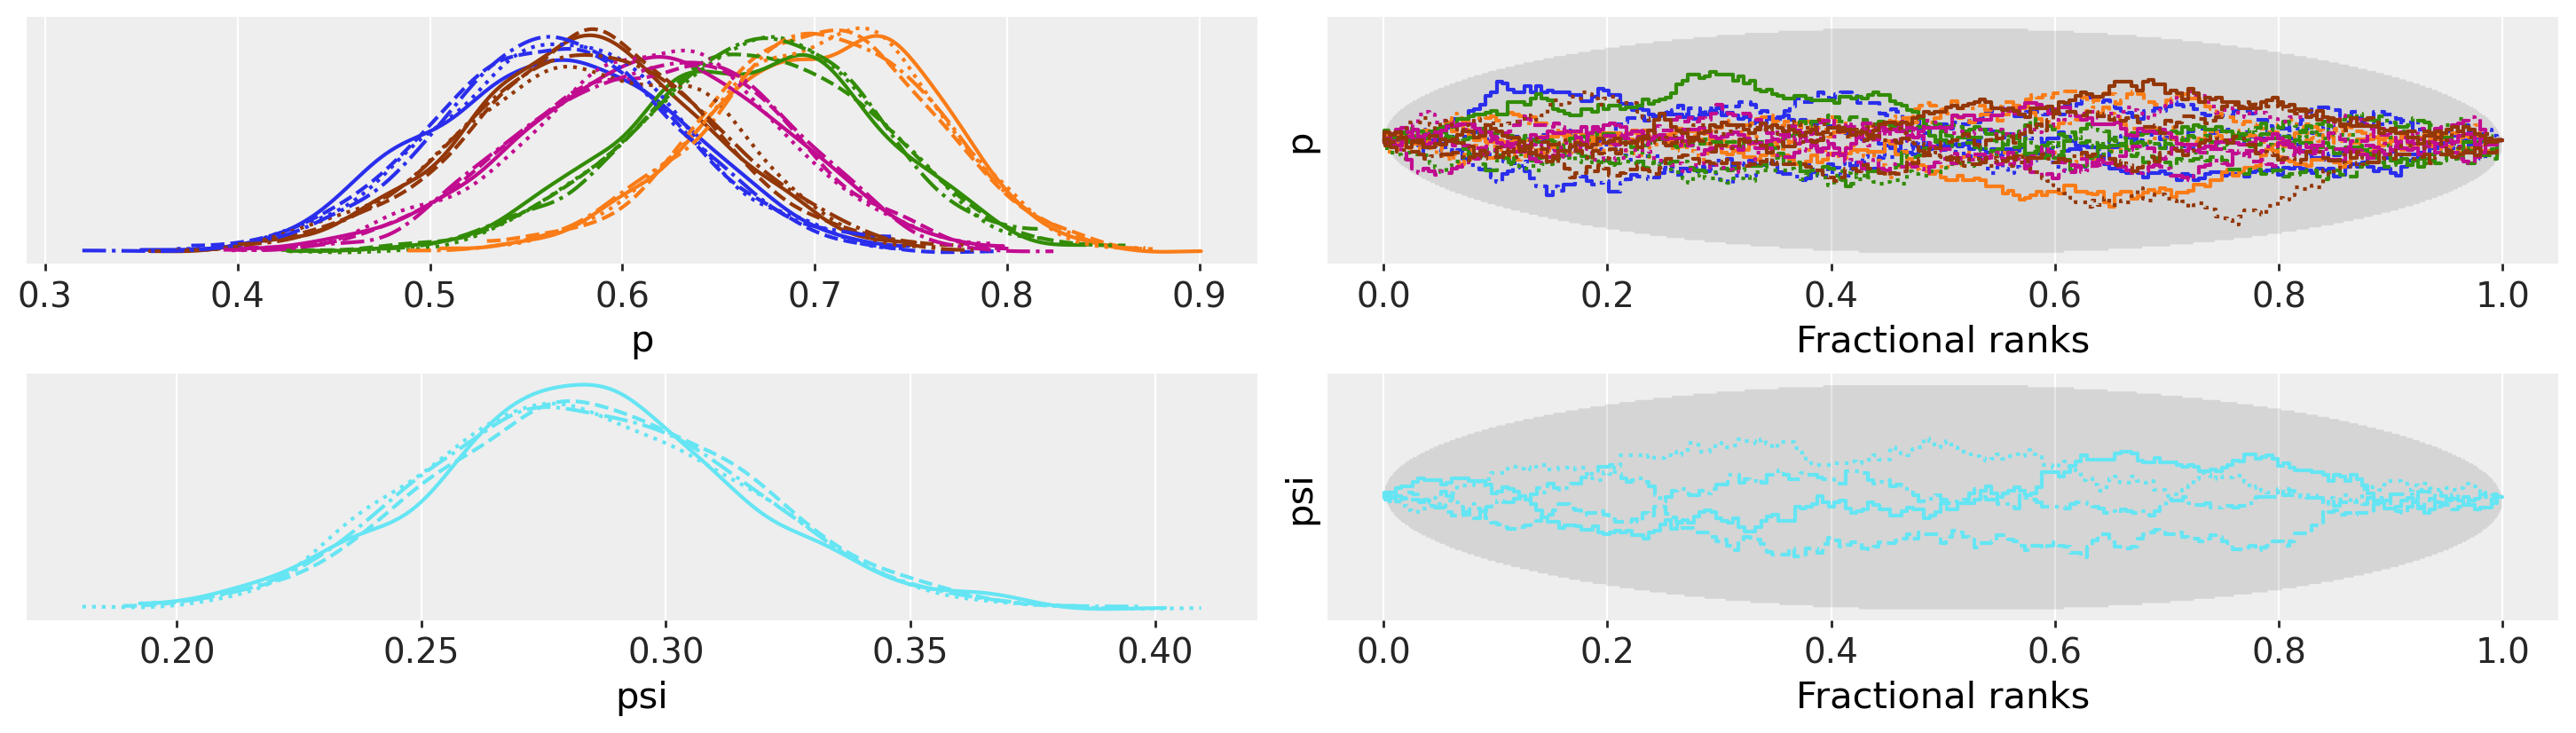

In [10]:
az.plot_rank_dist(mt_idata)

The capture probability might mildly vary between sessions, but this had zero effect on our population size estimate, since $\hat{\psi}=0.28$ once again.

## Model $M_b$: behavioral response

These traps have been baited with corn. The voles might find that they like the corn, and that one night being safe in a trap is not so bad. Alternatively, they may have been horrified the experience and avoid being trapped again. Either way, there might be a behavioral response, such that the capture probability changes after the individual has been captured. Model $M_b$ tries to estimate this response. There are several flavors of $M_b$, but we will assume that the effect kicks in after the first capture and is permanent. 

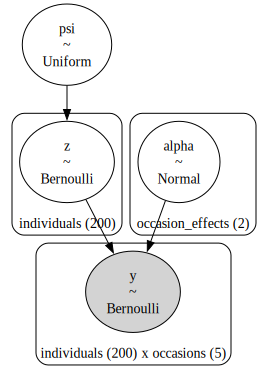

In [11]:
# this is the occasion when each individual was first seen
first_seen = (augmented_dataset != 0).argmax(axis=1)

# each row of behavior_effect switches to one permanently
behavior_effect = np.zeros((M, T))
for i, f in enumerate(first_seen):
    behavior_effect[i, (f + 1) :] = 1

# create a design matrix that includes an intercept and the effect
x_int = np.ones((M, T))
X = np.stack((x_int, behavior_effect), axis=2)

# pymc model
coords.update({"occasion_effects": ["intercept", "behavioral_effect"]})
with pm.Model(coords=coords) as mb:

    # priors for the capture and inclusion probabilities
    psi = pm.Uniform("psi", 0, 1)
    alpha = pm.Normal("alpha", 0, 2, dims="occasion_effects")

    # linear model for the capture probability
    p = pm.math.invlogit(pm.math.dot(X, alpha))

    # included / excluded state
    z = pm.Bernoulli("z", psi, dims=["individuals"])

    # likelihood of capture given inclusion
    pm.Bernoulli("y", z[:, None] * p, observed=augmented_dataset, dims=["individuals", "occasions"])

pm.model_to_graphviz(mb)

In [12]:
# marginalize the model before sampling
mb_marginal = pmx.marginalize(mb, ["z"])
with mb_marginal:
    mb_idata = pm.sample(random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(mb_idata)

az.summary(mb_idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
alpha[intercept],0.26,0.20,-0.05,0.59,2150.33,2335.96,1.0,0.00,0.0
alpha[behavioral_effect],0.45,0.26,0.04,0.86,2010.46,2116.19,1.0,0.01,0.0
psi,0.28,0.03,0.23,0.34,2833.09,2465.16,1.0,0.00,0.0


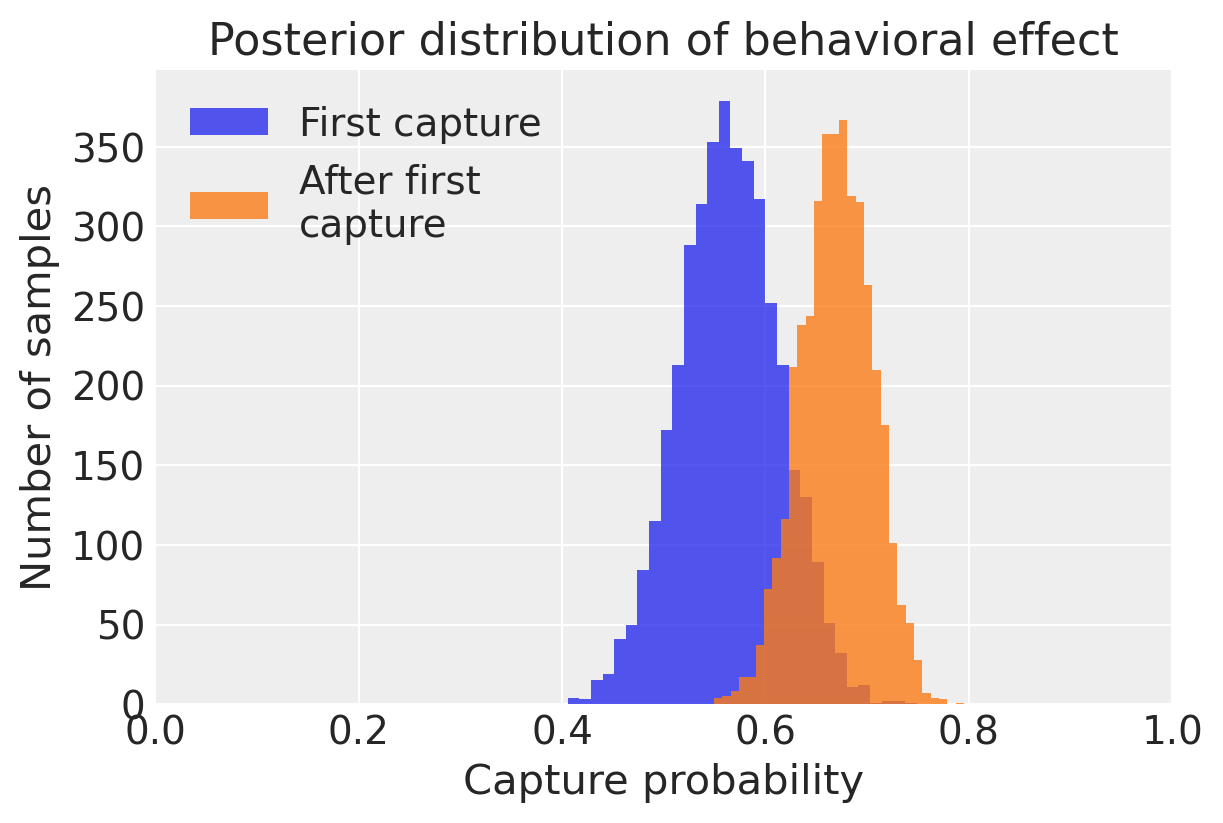

In [13]:
posterior_alpha = az.extract(mb_idata).alpha.values
posterior_p_first_capture = invlogit(posterior_alpha[0])
posterior_p_after = invlogit(posterior_alpha[0] + posterior_alpha[1])

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(posterior_p_first_capture, label="First capture", color="C0", alpha=0.8, bins=30)
ax.hist(posterior_p_after, label="After first\ncapture", color="C1", alpha=0.8, bins=30)
ax.set_title("Posterior distribution of behavioral effect")
ax.set_xlim((0, 1))
ax.set_xlabel("Capture probability")
ax.set_ylabel("Number of samples")
ax.legend()
plt.show()

There does seem to be a slight increase in capture probability after the voles have been captured the first time. In the jargon of capture-recapture, they seem to be "trap happy". Corn and safety is a winning combination! Accounting for this effect, however, had no effect on our abundance estimate, since $\hat{\psi}=0.28$ once again.

## Model $M_h$: capture probability varies by individual

Perhaps every vole varies in their eagerness for corn and safety. Models that account for this variation are known as model $M_h$, where the $h$ stands for *individual heterogeneity*. As you might guess by now, there are many flavors of model $M_h$. Taking a cue from the {ref}`hierarchical partial pooling notebook <hierarchical_partial_pooling>`, we will model this individual variation with two hyper parameters: $\phi$, which describes the overall average capture probability, and $\kappa$, which describes the number the variation in capture probability among individuals. This model is challenging to sample, so we will increase the tuning samples, 

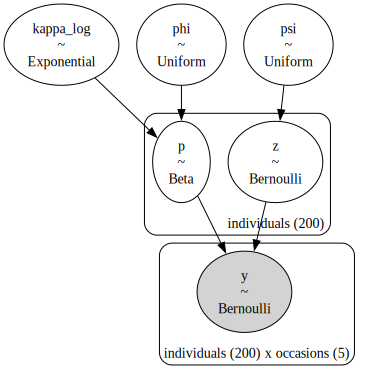

In [14]:
with pm.Model(coords=coords) as mh:

    # prior inclusion probabilities
    psi = pm.Uniform("psi", 0, 1)

    # overall average
    phi = pm.Uniform("phi", 0, 1)

    # individual level variation
    kappa_log = pm.Exponential("kappa_log", lam=1)
    kappa = pm.math.exp(kappa_log)
    p = pm.Beta("p", alpha=phi * kappa, beta=(1.0 - phi) * kappa, dims="individuals")

    # included / excluded state
    z = pm.Bernoulli("z", psi, dims="individuals")

    # likelihood of capture given inclusion
    pm.Bernoulli(
        "y", z[:, None] * p[:, None], observed=augmented_dataset, dims=["individuals", "occasions"]
    )

pm.model_to_graphviz(mh)

In [15]:
# marginalize the model before sampling
mh_marginal = pmx.marginalize(mh, ["z"])
with mh_marginal:
    mh_idata = pm.sample(tune=2000, samples=2000, random_seed=RANDOM_SEED, target_accept=0.99)
    pm.compute_log_likelihood(mh_idata)

az.summary(mh_idata, var_names=["psi", "phi", "kappa_log"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa_log, phi, p, psi]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
psi,0.37,0.06,0.28,0.47,278.83,555.73,1.01,0.00,0.00
phi,0.49,0.08,0.36,0.61,179.66,344.83,1.02,0.01,0.00
kappa_log,0.33,0.27,0.03,0.84,135.57,121.74,1.03,0.03,0.02


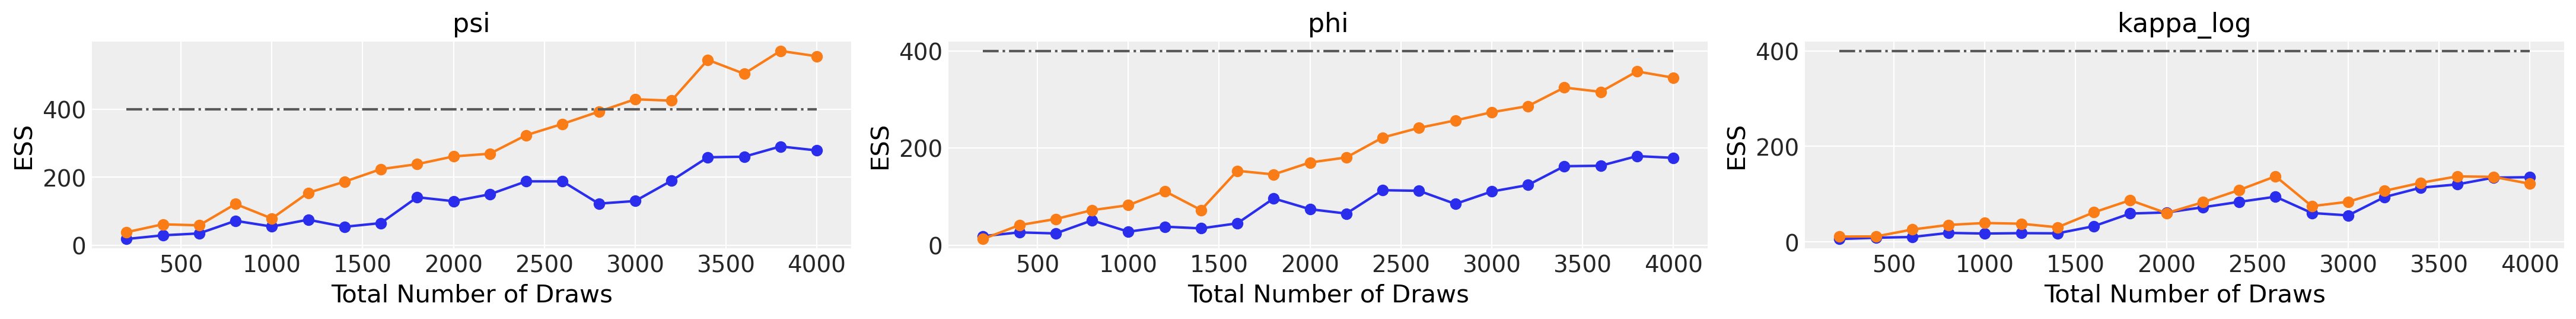

In [16]:
az.plot_ess_evolution(mh_idata, var_names=["psi", "phi", "kappa_log"])

Unsurprisingly, the model struggles to sample the variance parameter $\kappa$, despite the increased number of samples and target acceptance probability. Nevertheless, we might consider this wor

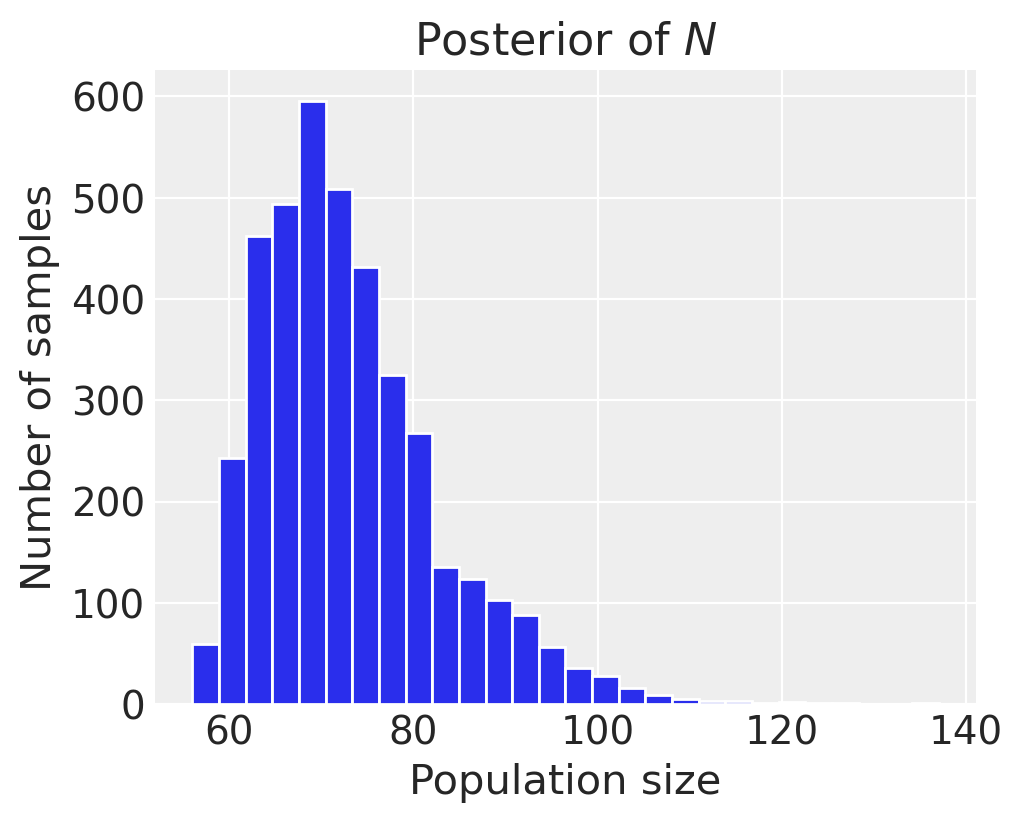

In [17]:
# posterior_N = az.extract(mh_idata).z.sum(axis=0)
mh_idata = pmx.recover_marginals(mh_idata, model=mh_marginal, var_names="z")
posterior_N = az.extract(mh_idata).z.sum(dim="individuals")

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(posterior_N, bins=28, ec="w")
ax.set_ylabel("Number of samples")
ax.set_xlabel("Population size")
ax.set_title(r"Posterior of $N$")
plt.show()

## Conclusion 

We have estimated the size of the vole population with four different models that varied in their treatment of the capture probability, $p$. Three models gave us the same abundance estimate, while the fourth, $M_h$ gave us a larger estimate. These differences could be important for policy making. So how do we decide which is correct? Let's try comparing the models with `az.loo`. 

In [18]:
%%capture --no-display

az.compare(
    {
        "m0": m0_idata,
        "mt": mt_idata,
        "mb": mb_idata,
        "mh": mh_idata,
    }
)

,rank,elpd,p,elpd_diff,weight,se,dse,warning
mh,0,-275.677662,38.953207,0.000000,1.0,25.100966,0.000000,True
mb,1,-303.696506,3.643577,28.018845,0.0,27.668531,6.464112,False
m0,2,-304.384054,3.030750,28.706393,0.0,27.624891,6.880863,False
mt,3,-306.207285,6.107360,30.529624,0.0,27.859692,7.320395,False


We see that all of the weight is allocated to $M_h$, but that some samples might be exhibiting undue influence on the $\text{elpd}$ estimate. As such, we could conservatively accept one of the other three models as correct, reparameterize the model, or attempt another model selection procedure. 

We have demonstrated how to estimate the size of a closed population with parameter expanded data augmentation. One benefit of this approach is that it allows us to easily incorporate individual covariates, which opens the door to another analyses, such as spatial capture-recapture. 

## Authors
- Authored by [Philip T. Patton](https://github.com/philpatton) in January 2026 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue, 03 Feb 2026

Python implementation: CPython
Python version       : 3.14.2
IPython version      : 9.9.0

pytensor: 2.37.0

arviz      : 0.23.1
matplotlib : 3.10.8
numpy      : 2.3.5
pandas     : 3.0.0
pymc       : 5.27.1
pymc_extras: 0.7.0

Watermark: 2.6.0



:::{include} ../page_footer.md
:::